In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, RandomResizedCrop

In [2]:
class ColorizationDataset(Dataset):
    def __init__(self, root_dir, transform_gray=None, transform_color=None):
        """
        Args:
            root_dir (str): Directory containing 'gray' and 'color' subfolders.
            transform_gray (callable, optional): Transform to apply to grayscale images.
            transform_color (callable, optional): Transform to apply to color images.
        """
        self.gray_dir = os.path.join(root_dir, "gray")
        self.color_dir = os.path.join(root_dir, "color")
        
        # Load file names and ensure both have matching pairs
        self.gray_images = sorted(os.listdir(self.gray_dir))
        self.color_images = sorted(os.listdir(self.color_dir))
        assert len(self.gray_images) == len(self.color_images), "Mismatch in dataset sizes!"
        
        self.transform_gray = transform_gray
        self.transform_color = transform_color

    def __len__(self):
        return len(self.gray_images)

    def __getitem__(self, idx):
        # Load grayscale image
        gray_path = os.path.join(self.gray_dir, self.gray_images[idx])
        gray_image = Image.open(gray_path).convert("L")  # Ensure grayscale
        
        # Load color image
        color_path = os.path.join(self.color_dir, self.color_images[idx])
        color_image = Image.open(color_path).convert("RGB")  # Ensure RGB
        
        # Apply transforms if provided
        if self.transform_gray:
            gray_image = self.transform_gray(gray_image)
        if self.transform_color:
            color_image = self.transform_color(color_image)
        
        return gray_image, color_image



transform_gray = transforms.Compose([
    transforms.RandomResizedCrop((256, 256), scale=(0.8, 1.0)),  # Randomly crop and resize
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomRotation(10),  # Random rotation within 10 degrees
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize (mean, std) for grayscale
])

transform_color = transforms.Compose([
    transforms.RandomResizedCrop((256, 256), scale=(0.8, 1.0)),  # Randomly crop and resize
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomRotation(10),  # Random rotation within 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color properties
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize (mean, std) for RGB
])


In [3]:
train_dataset = ColorizationDataset(
    root_dir="/kaggle/input/genai-dataset-project/train",
    transform_gray=transform_gray,
    transform_color=transform_color
)

test_dataset = ColorizationDataset(
    root_dir="/kaggle/input/genai-dataset-project/test",
    transform_gray=transform_gray,
    transform_color=transform_color
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# Check a batch of data
for gray_batch, color_batch in train_loader:
    print("Gray batch shape:", gray_batch.shape)  # Should be [batch_size, 1, 256, 256]
    print("Color batch shape:", color_batch.shape)  # Should be [batch_size, 3, 256, 256]
    break

Gray batch shape: torch.Size([16, 1, 256, 256])
Color batch shape: torch.Size([16, 3, 256, 256])


In [4]:
# Import necessary libraries
from torchvision.models.segmentation import fcn_resnet50
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define the Pix2Pix Generator model
class Pix2PixGenerator(nn.Module):
    def __init__(self, pretrained=True):
        super(Pix2PixGenerator, self).__init__()
        # Pretrained FCN with ResNet backbone for colorization
        self.model = fcn_resnet50(pretrained=pretrained)
        
        # Modify the input layer to accept 1 channel (grayscale input)
        self.model.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Modify the output layer for RGB prediction
        self.model.classifier[4] = nn.Conv2d(512, 3, kernel_size=1)

    def forward(self, x):
        output = self.model(x)['out']
        return torch.tanh(output)  # Normalize output to [-1, 1]

# Define a simple Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(256 * 32 * 32, 1),  # Adjust dimensions for your image size
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Pix2PixGenerator(pretrained=True).to(device)
discriminator = Discriminator().to(device)



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:00<00:00, 209MB/s]


In [5]:
# Training loop
num_epochs = 20
loss_history_G = []
loss_history_D = []


# Loss functions
adversarial_loss = nn.BCELoss()  # Binary Cross-Entropy for adversarial loss
pixelwise_loss = nn.L1Loss()  # L1 loss for pixel-wise reconstruction

# Optimizers
learning_rate = 0.0002
beta1 = 0.5
beta2 = 0.999

optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, beta2))


# Verify DataLoader works correctly
gray_batch, color_batch = next(iter(train_loader))
print("Gray Batch Shape:", gray_batch.shape)
print("Color Batch Shape:", color_batch.shape)

# Training process
for epoch in range(num_epochs):
    generator.train()
    discriminator.train()

    running_loss_G = 0.0
    running_loss_D = 0.0

    # tqdm console mode to avoid "Loading widget" errors
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=True)

    for gray_batch, color_batch in loop:
        # Move data to the appropriate device
        gray_batch = gray_batch.to(device)
        color_batch = color_batch.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        
        # Real images
        real_labels = torch.ones((color_batch.size(0), 1), device=device)
        real_loss = adversarial_loss(discriminator(color_batch), real_labels)

        # Fake images
        fake_images = generator(gray_batch)
        fake_labels = torch.zeros((color_batch.size(0), 1), device=device)
        fake_loss = adversarial_loss(discriminator(fake_images.detach()), fake_labels)

        # Total discriminator loss
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        
        # Generator losses
        fake_images = generator(gray_batch)
        g_adv_loss = adversarial_loss(discriminator(fake_images), real_labels)
        g_pixel_loss = pixelwise_loss(fake_images, color_batch)
        g_loss = g_adv_loss + g_pixel_loss
        g_loss.backward()
        optimizer_G.step()

        # Record losses
        running_loss_G += g_loss.item()
        running_loss_D += d_loss.item()
        loop.set_postfix(g_loss=g_loss.item(), d_loss=d_loss.item())

    # Average losses per epoch
    loss_history_G.append(running_loss_G / len(train_loader))
    loss_history_D.append(running_loss_D / len(train_loader))
    print(f"Epoch [{epoch+1}/{num_epochs}] - G Loss: {loss_history_G[-1]:.4f}, D Loss: {loss_history_D[-1]:.4f}")



Gray Batch Shape: torch.Size([16, 1, 256, 256])
Color Batch Shape: torch.Size([16, 3, 256, 256])


Epoch [1/20]: 100%|██████████| 714/714 [19:50<00:00,  1.67s/it, d_loss=9.18e-6, g_loss=66.1]


Epoch [1/20] - G Loss: 22.4126, D Loss: 0.4718


Epoch [2/20]: 100%|██████████| 714/714 [17:48<00:00,  1.50s/it, d_loss=1.95e-11, g_loss=36.9]


Epoch [2/20] - G Loss: 54.4309, D Loss: 0.2049


Epoch [3/20]: 100%|██████████| 714/714 [17:53<00:00,  1.50s/it, d_loss=0.236, g_loss=60.4]


Epoch [3/20] - G Loss: 49.7486, D Loss: 0.1460


Epoch [4/20]: 100%|██████████| 714/714 [18:04<00:00,  1.52s/it, d_loss=0.677, g_loss=91.1]


Epoch [4/20] - G Loss: 65.8318, D Loss: 0.0948


Epoch [5/20]: 100%|██████████| 714/714 [17:57<00:00,  1.51s/it, d_loss=0.000106, g_loss=68.9]


Epoch [5/20] - G Loss: 72.1420, D Loss: 0.0814


Epoch [6/20]: 100%|██████████| 714/714 [17:50<00:00,  1.50s/it, d_loss=0, g_loss=101]


Epoch [6/20] - G Loss: 65.7343, D Loss: 0.0793


Epoch [7/20]: 100%|██████████| 714/714 [17:54<00:00,  1.51s/it, d_loss=0.000356, g_loss=73.5]


Epoch [7/20] - G Loss: 78.8168, D Loss: 0.0560


Epoch [8/20]: 100%|██████████| 714/714 [17:59<00:00,  1.51s/it, d_loss=6.22e-19, g_loss=52.4]


Epoch [8/20] - G Loss: 78.3590, D Loss: 0.0232


Epoch [9/20]: 100%|██████████| 714/714 [17:52<00:00,  1.50s/it, d_loss=1.67e-30, g_loss=97.9]


Epoch [9/20] - G Loss: 89.9803, D Loss: 0.0297


Epoch [10/20]: 100%|██████████| 714/714 [17:51<00:00,  1.50s/it, d_loss=1.5e-10, g_loss=39]


Epoch [10/20] - G Loss: 81.0267, D Loss: 0.2360


Epoch [11/20]: 100%|██████████| 714/714 [17:51<00:00,  1.50s/it, d_loss=3.55e-29, g_loss=83.5]


Epoch [11/20] - G Loss: 83.4988, D Loss: 0.0155


Epoch [12/20]: 100%|██████████| 714/714 [17:51<00:00,  1.50s/it, d_loss=3.17e-33, g_loss=92.4]


Epoch [12/20] - G Loss: 93.2607, D Loss: 0.0015


Epoch [13/20]: 100%|██████████| 714/714 [17:54<00:00,  1.50s/it, d_loss=0, g_loss=100]


Epoch [13/20] - G Loss: 96.5916, D Loss: 0.0297


Epoch [14/20]: 100%|██████████| 714/714 [17:49<00:00,  1.50s/it, d_loss=0, g_loss=100]


Epoch [14/20] - G Loss: 100.1554, D Loss: 0.0046


Epoch [15/20]: 100%|██████████| 714/714 [17:51<00:00,  1.50s/it, d_loss=1.12e-40, g_loss=99.4]


Epoch [15/20] - G Loss: 100.2544, D Loss: 0.0000


Epoch [16/20]: 100%|██████████| 714/714 [17:39<00:00,  1.48s/it, d_loss=0, g_loss=100]


Epoch [16/20] - G Loss: 100.2614, D Loss: 0.0000


Epoch [17/20]: 100%|██████████| 714/714 [17:59<00:00,  1.51s/it, d_loss=0, g_loss=101]


Epoch [17/20] - G Loss: 96.8610, D Loss: 1.1144


Epoch [18/20]: 100%|██████████| 714/714 [17:55<00:00,  1.51s/it, d_loss=4.77e-20, g_loss=90.6]


Epoch [18/20] - G Loss: 99.5815, D Loss: 0.0889


Epoch [19/20]: 100%|██████████| 714/714 [17:53<00:00,  1.50s/it, d_loss=0, g_loss=100]


Epoch [19/20] - G Loss: 100.1612, D Loss: 0.0042


Epoch [20/20]: 100%|██████████| 714/714 [17:44<00:00,  1.49s/it, d_loss=0, g_loss=100]

Epoch [20/20] - G Loss: 99.9179, D Loss: 0.0283


In [6]:
# Save models
torch.save(generator.state_dict(), "Pix2Pix_Generator.pth")
torch.save(discriminator.state_dict(), "Pix2Pix_Discriminator.pth")



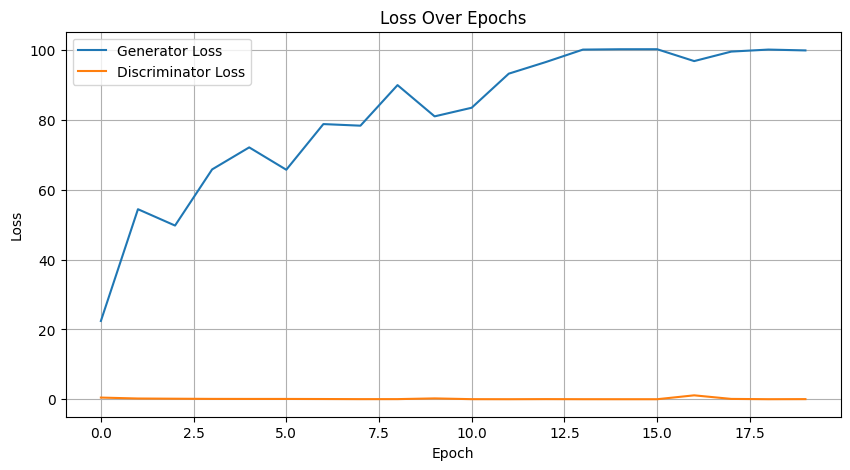

In [7]:
# Plot loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_history_G, label="Generator Loss")
plt.plot(loss_history_D, label="Discriminator Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


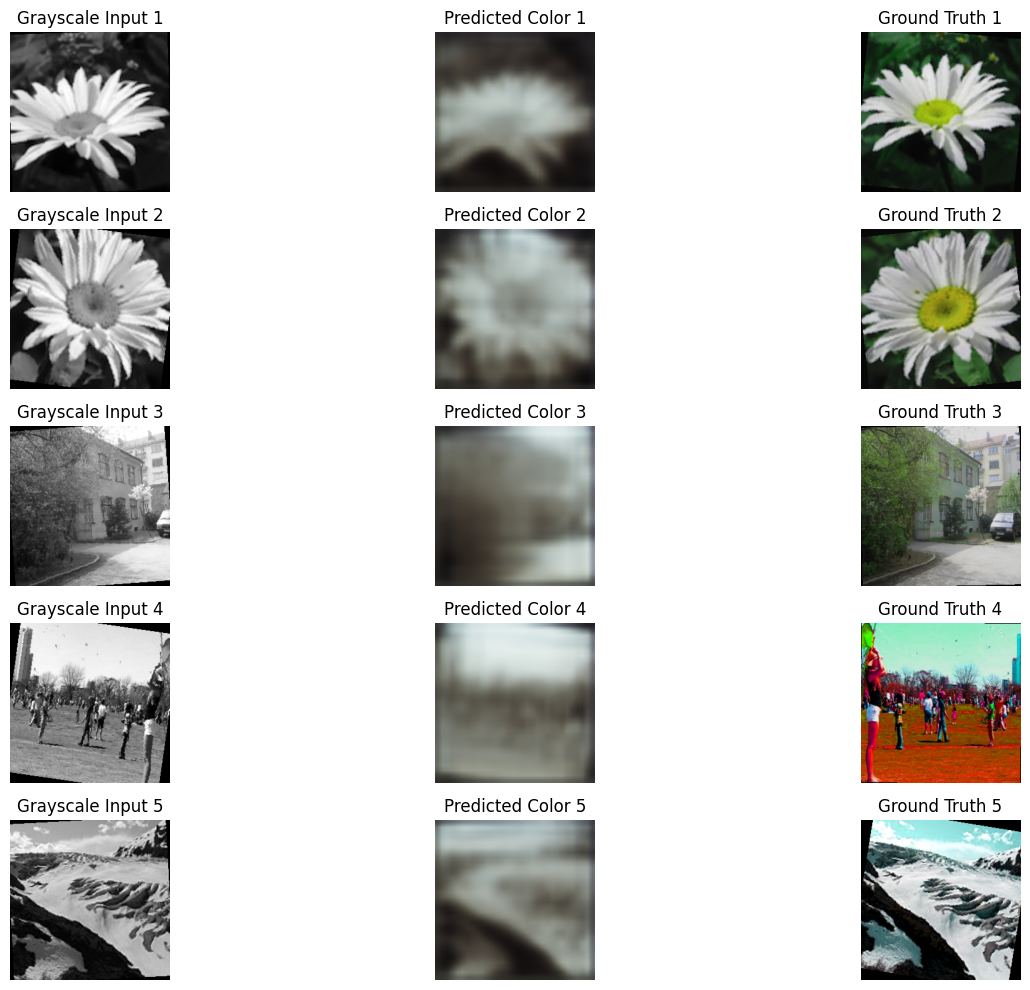

In [8]:
import matplotlib.pyplot as plt

# Visualize the results on a single batch
generator.eval()
with torch.no_grad():
    for gray_batch, color_batch in test_loader:
        # Move data to the appropriate device
        gray_batch = gray_batch.to(device)
        color_batch = color_batch.to(device)

        # Generate colorized images
        predicted_colors = generator(gray_batch)

        # Move data to CPU and convert to numpy for visualization
        gray_images = gray_batch.cpu().numpy()
        predicted_colors = predicted_colors.cpu().numpy()
        true_colors = color_batch.cpu().numpy()

        # Display the first 5 samples in the batch
        num_images = 5  # Adjust this to display more/less images
        plt.figure(figsize=(15, 10))
        for i in range(num_images):
            # Grayscale Input
            plt.subplot(num_images, 3, i * 3 + 1)
            plt.title(f"Grayscale Input {i+1}")
            plt.imshow(gray_images[i][0], cmap="gray")  # Display grayscale image
            plt.axis("off")

            # Predicted Color
            plt.subplot(num_images, 3, i * 3 + 2)
            plt.title(f"Predicted Color {i+1}")
            plt.imshow(predicted_colors[i].transpose(1, 2, 0) * 0.5 + 0.5)  # De-normalize and display
            plt.axis("off")

            # True Color
            plt.subplot(num_images, 3, i * 3 + 3)
            plt.title(f"Ground Truth {i+1}")
            plt.imshow(true_colors[i].transpose(1, 2, 0) * 0.5 + 0.5)  # De-normalize and display
            plt.axis("off")

        plt.tight_layout()
        plt.show()
        break  # Process only the first batch


In [9]:
import torch
import torch.nn.functional as F

def evaluate_psnr(model, test_loader, device):
    model.eval()
    total_psnr = 0
    count = 0
    
    with torch.no_grad():
        for gray_batch, color_batch in test_loader:
            gray_batch = gray_batch.to(device)
            color_batch = color_batch.to(device)
            
            # Generate the colorized image
            generated_image = model(gray_batch)
            
            # Calculate PSNR
            mse = F.mse_loss(generated_image, color_batch, reduction='mean')
            psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))  # Assuming images are normalized to [0, 1]
            total_psnr += psnr.item()
            count += 1

    return total_psnr / count


In [10]:
# Install LPIPS (if not already installed)
!pip install lpips scikit-image



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.1 MB/s eta 0:00:00


In [11]:
import lpips

def evaluate_lpips(model, test_loader, device):
    model.eval()
    lpips_loss = lpips.LPIPS(net='alex').to(device)  # Use AlexNet backbone
    total_lpips = 0
    count = 0
    
    with torch.no_grad():
        for gray_batch, color_batch in test_loader:
            gray_batch = gray_batch.to(device)
            color_batch = color_batch.to(device)
            
            # Generate the colorized image
            generated_image = model(gray_batch)
            
            # Calculate LPIPS
            lpips_score = lpips_loss(generated_image, color_batch)
            total_lpips += lpips_score.mean().item()
            count += 1

    return total_lpips / count


In [12]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

def evaluate_ssim(model, test_loader, device):
    model.eval()
    total_ssim = 0
    count = 0

    with torch.no_grad():
        for gray_batch, color_batch in test_loader:
            gray_batch = gray_batch.to(device)
            color_batch = color_batch.to(device)
            
            # Generate the colorized image
            generated_image = model(gray_batch).cpu().numpy()
            target_image = color_batch.cpu().numpy()
            
            # Convert images to range [0, 255]
            generated_image = (generated_image * 255).astype(np.uint8)
            target_image = (target_image * 255).astype(np.uint8)
            
            # Calculate SSIM for each image in the batch
            for i in range(generated_image.shape[0]):
                generated_img = generated_image[i].transpose(1, 2, 0)
                target_img = target_image[i].transpose(1, 2, 0)
                
                # Ensure SSIM calculation works with explicit channel_axis
                ssim_score = ssim(
                    target_img,
                    generated_img,
                    channel_axis=-1,  # Use channel_axis instead of multichannel
                    win_size=7  # Explicitly set win_size to match SSIM requirements
                )
                total_ssim += ssim_score
                count += 1

    return total_ssim / count


In [13]:
# Evaluate PSNR
psnr = evaluate_psnr(generator, test_loader, device)
print(f"PSNR: {psnr:.2f} dB")

# Evaluate LPIPS
lpips_score = evaluate_lpips(generator, test_loader, device)
print(f"LPIPS: {lpips_score:.4f}")

ssim_score = evaluate_ssim(generator, test_loader, device)
print(f"SSIM: {ssim_score:.4f}")




PSNR: 6.80 dB
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 221MB/s]


Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


/opt/conda/lib/python3.10/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

LPIPS: 0.8926
SSIM: 0.1520
